In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import healpy as hp
import scipy
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads
from numba.typed import List, Dict
from tqdm.notebook import tqdm

import helper_funcs as hf
import bispec_calculator as bispec

## Testing Bins

In [3]:
lmax = 1024
ells = np.arange(1, lmax+1)

cls = (ells + 0.0)**(-3.)

theory_map, alms = hp.sphtfunc.synfast(cls=cls, nside=1024, lmax=lmax, alm=True)

sorted_alms = bispec.sort_alms(alms, lmax)

In [4]:
def create_bins_and_maps(sorted_alms, lmin, lmax, nbins):
    i1_bin, i2_bin, i3_bin = bispec.create_bins(lmin, lmax, nbins)
    i1_map, i2_map, i3_map = bispec.get_three_filtered_maps(sorted_alms, i1_bin, i2_bin, i3_bin)

    return i1_bin, i2_bin, i3_bin, i1_map, i2_map, i3_map

In [13]:
lmin = 100
lmax = 110
nbins = 10

i1_bin, i2_bin, i3_bin, i1_map, i2_map, i3_map = create_bins_and_maps(sorted_alms, lmin, lmax, nbins)

In [12]:
## Map Method

%timeit bispec.compute_binned_bispec(i1_bin, i2_bin, i3_bin, i1_map, i2_map, i3_map)

57.6 ms ± 667 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
## Filter Method

%timeit bispec.compute_averaged_bispec(i1_bin, i2_bin, i3_bin, sorted_alms)

427 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Log:

Bin: [2, 10, 1]

t_map = 56.1 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

t_filter = 9.07 ms ± 867 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

Bin: [2, 100, 1]

t_map = 57.6 ms ± 787 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

t_filter = DOESN'T FINISH (after 2min)

Bin: [20, 50, 5]

t_map = 56.5 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

t_filter = 229 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Bin: [20, 50, 2]

t_map = 57 ms ± 923 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

t_filter = 4.09 s ± 32.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Bin: [200, 500, 50]

t_map = 63.2 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

t_filter = DOESN'T FINISH (after 3min)

Bin = [100, 1000, 10]

t_map = 57.6 ms ± 667 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Bin: [100, 1000, 1]

t_map = 871 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

## Run Over Maps

In [10]:
def run_over_binned_maps(lmin_bin, lmax_bin, nbins, nmaps=10, ells=np.arange(1,1025,1), seed_start=160989):
    cls = (ells + 0.0)**(-3.)
    bls_maps = np.zeros(nmaps, dtype='float')
    for i in tqdm(range(nmaps)):
        np.random.seed(seed_start+i)
        _, alms = hp.sphtfunc.synfast(cls=cls, nside=1024, lmax=ells.max(), alm=True)
        sorted_alms = bispec.sort_alms(alms, lmax+1)
        i1_bin, i2_bin, i3_bin, i1_map, i2_map, i3_map = create_bins_and_maps(sorted_alms, lmin_bin, lmax_bin, nbins)
        bls_maps[i]  = bispec.compute_binned_bispec(i1_bin, i2_bin, i3_bin, i1_map, i2_map, i3_map)
    return bls_maps

In [11]:
def run_over_averaged_maps(lmin_bin, lmax_bin, nbins, nmaps=10, ells=np.arange(1,1025,1), seed_start=160989):
    cls = (ells + 0.0)**(-3.)
    bls = np.zeros(nmaps, dtype='float')
    for i in tqdm(range(nmaps)):
        np.random.seed(seed_start+i)
        _, alms = hp.sphtfunc.synfast(cls=cls, nside=1024, lmax=ells.max(), alm=True)
        sorted_alms = bispec.sort_alms(alms, lmax+1)
        i1_bin, i2_bin, i3_bin = bispec.create_bins(lmin_bin, lmax_bin, nbins)
        bls[i]  = bispec.compute_averaged_bispec(i1_bin, i2_bin, i3_bin, sorted_alms)
    return bls

In [13]:
nmaps = 25
lmin = 30
lmax = 50
nbins = 1

ls = np.arange(lmin, lmax+1, nbins)

# bls_maps = run_over_binned_maps(lmin, lmax, nbins, nmaps=nmaps)
bls = run_over_averaged_maps(lmin, lmax, nbins, nmaps=nmaps)

  0%|          | 0/25 [00:00<?, ?it/s]

in original implementation, not binned, so we had bispec value for each ell triplet. How to implement for bin?

ValueError: x and y must have same first dimension, but have shapes (21,) and (1,)

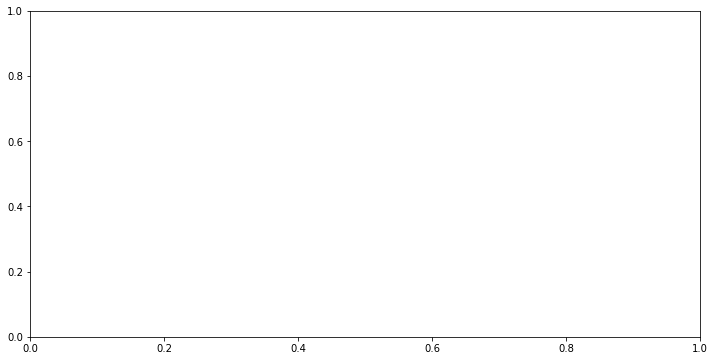

In [16]:
temp_ells = np.arange(lmin, lmax+1, nbins)

plt.figure(figsize=(12,6))
for i in range(nmaps):
    plt.plot(temp_ells, bls[i])
plt.title(f"gaussian bispectra for nmaps={nmaps} and bins={nbins}")
plt.xlabel("multipole triplet $(\ell_1,\ell_2,\ell_3)$", fontsize=18)
plt.ylabel("$B^{gauss}_{\ell_1, \ell_2, \ell_3}$", fontsize=18)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.show()
plt.figure(figsize=(12,6))
plt.errorbar(temp_ells, np.abs(np.mean(bls, 0)), np.std(bls, 0)/np.sqrt(nmaps))
plt.title("bispectra error spread", fontsize=18)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel("multipole triplet $(\ell_1,\ell_2,\ell_3)$", fontsize=18)
plt.ylabel("mean $B^{gauss}_{\ell_1, \ell_2, \ell_3}$", fontsize=18)
plt.yscale('log')
plt.show()